In [1]:
DATASET="rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000-012.root"

In [2]:
from mu2etools import wideband
from mu2etools import *

processor = wideband.DataProcessor(usexroot=True, fixtimes=False)
ar = processor.getData(DATASET)

In [3]:
#list = processor.getFilelist(DATASET)
#file_list_ = ["{}{}".format(i, ":%s"%"runSummary") for i in list]
#ar = uproot.concatenate(file_list_, xrootdsource={"timeout": 720})

In [4]:
list_febID = ar['febID'].to_list()
FEBID = min(list_febID, key=lambda x: len(x))

NFEBS=len(FEBID)
print("Dataset: %s"%DATASET)
print("Number of FEBs: %d"%NFEBS)
print("List of FEBs: %s"%FEBID)

Dataset: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000-012.root
Number of FEBs: 8
List of FEBs: [22, 25, 17, 14, 20, 1, 18, 5]


Temperature at CMB vs time

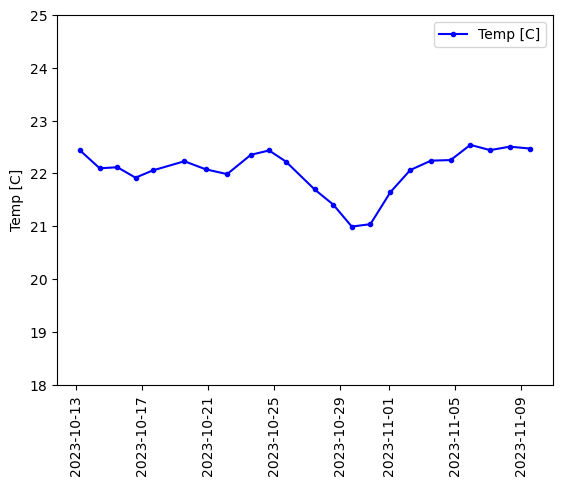

In [5]:
cut = (ar['timestamp'] > 0)
x=ar["timestamp", cut].to_numpy()
y=ar["meanTemperatures", cut][:,1,0].to_numpy()
    
plt.plot(x.astype('datetime64[s]'), y, 'b.-', label='Temp [C]')
plt.xticks(rotation=90);
plt.ylim(18, 25)
plt.ylabel('Temp [C]')
plt.legend();

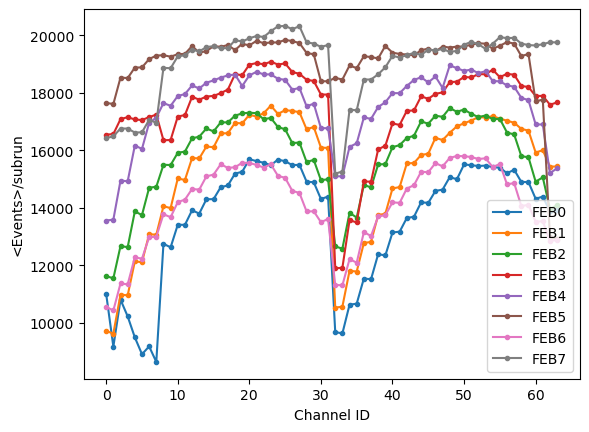

In [6]:
for feb in range(NFEBS):
    plt.plot(ak.mean(ar['signals'][:,feb,:], axis=0), '.-', label='FEB%d'%feb);
plt.ylabel('<Events>/subrun')
plt.xlabel('Channel ID')
plt.legend();

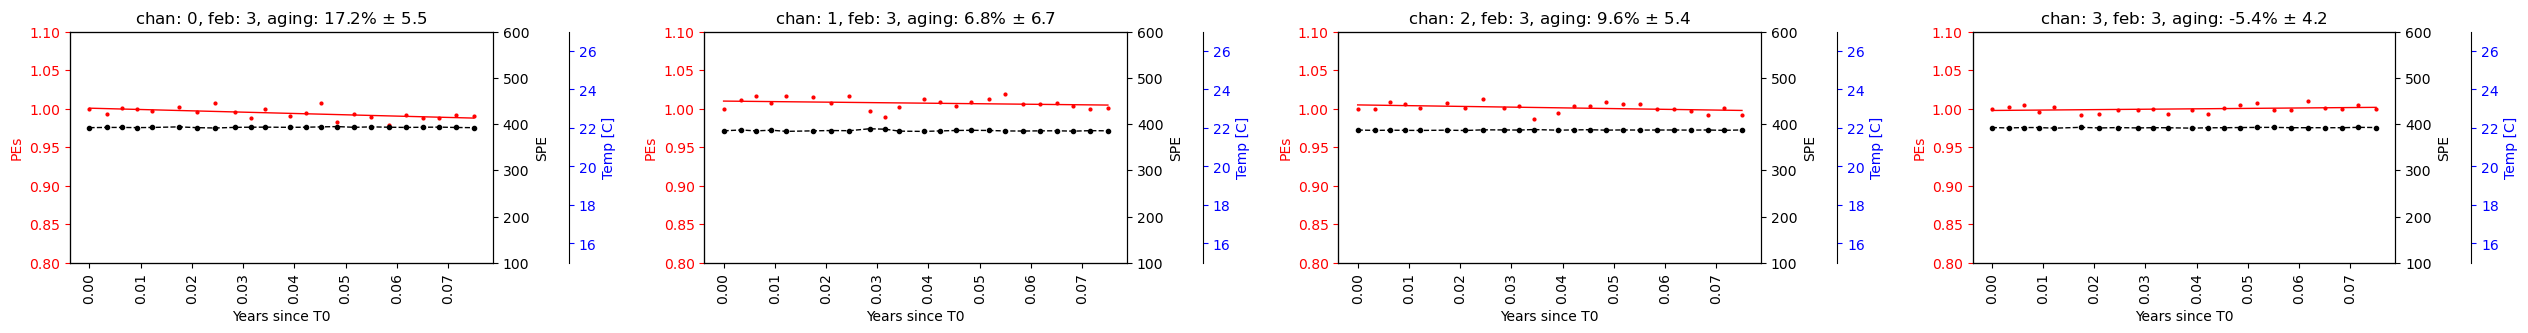

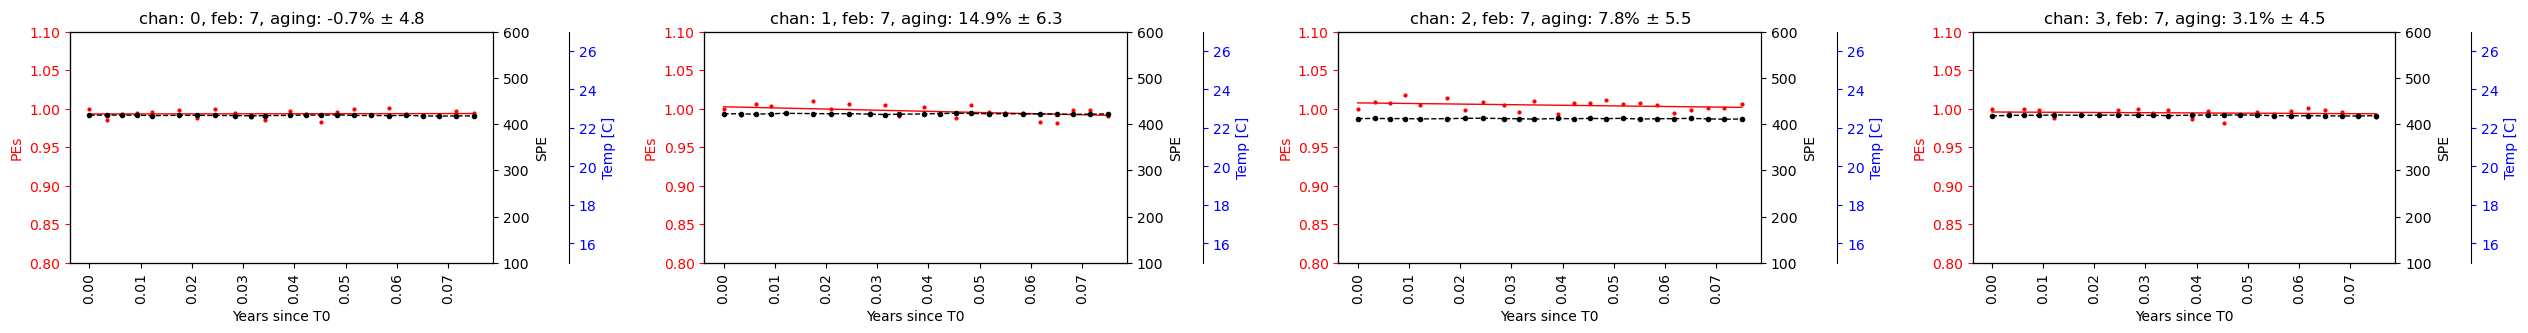

In [7]:
# Define the exponential function to fit
def func(x, a, b):
    return a * np.exp(-b*x/100) # return aging rate in %
#    return a -b*x/100 # return aging rate in %

df_age = pd.DataFrame(columns=['age_rate', 'age_rate_std', 'res_std', 'chi2', 'chan', 'feb'])

ar_=ar
for feb in [3,7]:
    
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(30, 3))

    plt.subplots_adjust(wspace=0.5)
    plt.xticks(rotation=90)    
    
    for chan_infeb in range(wideband.NCHAN_FEB):

        chan = chan_infeb%wideband.NCHAN_CMB        
        # Remove channels with low number of entries
        cut = (ar_['signals'][:, feb, chan_infeb] > 2000) 
        y = ar_['PEsTemperatureCorrected', cut][:, feb, chan_infeb].to_numpy()
        y = y / y[0]
        t0 = ar_['timestamp', cut][0]
        x = (ar_['timestamp', cut] - t0)/wideband.SEC_YEAR
        x = x.to_numpy()        
        popt, pcov = curve_fit(func, x, y, p0=[1, 5])
        
        a, age_rate = popt
        y_fit = func(x, a, age_rate)

        age_rate_std = np.sqrt(np.diag(pcov))[1] # Aging rate error 
        residuals = y - y_fit
        res_std = np.std(residuals)
        chisq = np.sum(residuals**2)
        dof = len(x) - len(popt)
        reduced_chi2 = chisq/dof
            
        # Plot only first 4 channels from FEBs
        if chan_infeb < 4:
            ax1 = ax[chan_infeb]
            ax1.set_title('chan: %d, feb: %d, aging: %.1f%% $\pm$ %.1f'%(chan_infeb,feb,age_rate,age_rate_std))
            ax1.plot(x, y_fit, 'r-', linewidth=1, label='Fit')
            ax1.set_ylim(0.8, 1.1)
            ax1.set_ylabel('PEs', color='r')
            ax1.set_xlabel('Years since T0')
            ax1.tick_params(axis='y', which='both', colors='r')
            ax1.tick_params(axis='x', rotation=90)
            ax1.plot(x, y, 'ro', markersize=2.0)

            y = ar_['calibConstantsTemperatureCorrected', cut][:, feb, chan_infeb].to_numpy()
            
            ax2 = ax1.twinx()
            ax2.plot(x, y, 'k.--', linewidth=1)
            ax2.set_ylim(100, 600)
            ax2.set_ylabel('SPE', color='k')

            y = ar_['meanTemperatures', cut][:, 0, 0].to_numpy()
            ax3 = ax1.twinx()
            ax3.plot(x, y, 'b.', markersize=2.0)
            ax3.spines['right'].set_position(("axes", 1.18))
            ax3.set_ylabel('Temp [C]', color='b')
            ax3.set_ylim(15, 27)
            ax3.tick_params(axis='y', which='both', colors='b')

        #fill dataframe
        new_row = {'age_rate': age_rate, 'age_rate_std':age_rate_std, 'res_std':res_std, 'chi2':reduced_chi2, 'chan':chan_infeb, 'feb':feb}
        df_age.loc[len(df_age)] = new_row
        
df_age['chi2_norm'] = df_age['chi2']/(df_age['res_std']**2).mean()

In [8]:
#top two: tape wrapped, connected to FEB7 (#5) channel 1-8
#bottom two: plastic wrapped; connected to FEB3 (#14) channel 1-8
df_age.query('chan<8')

,age_rate,age_rate_std,res_std,chi2,chan,feb,chi2_norm
0,17.237442,5.515514,0.005732,0.000036,0,3,0.955342
1,6.824227,6.651266,0.007002,0.000054,1,3,1.425864
2,9.560492,5.440092,0.005693,0.000036,2,3,0.942600
3,-5.399972,4.188741,0.004376,0.000021,3,3,0.556922
4,0.142917,4.773006,0.004991,0.000027,4,3,0.724292
5,0.900995,3.826988,0.004019,0.000018,5,3,0.469612
6,12.492858,5.258978,0.005455,0.000033,6,3,0.865171
7,10.273135,5.427869,0.005697,0.000036,7,3,0.943773
64,-0.713843,4.801608,0.004985,0.000027,0,7,0.722680
65,14.886661,6.269670,0.006533,0.000047,1,7,1.241144


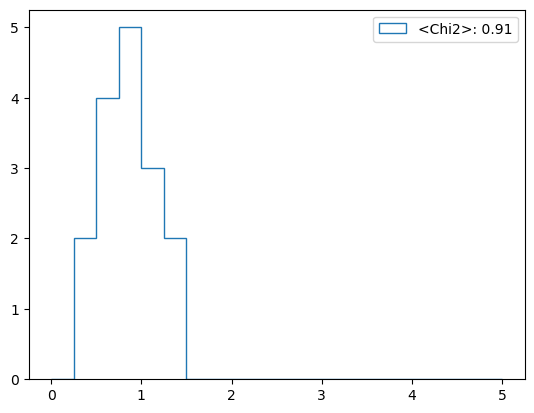

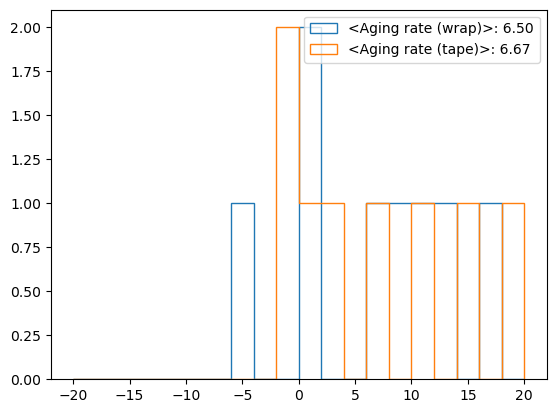

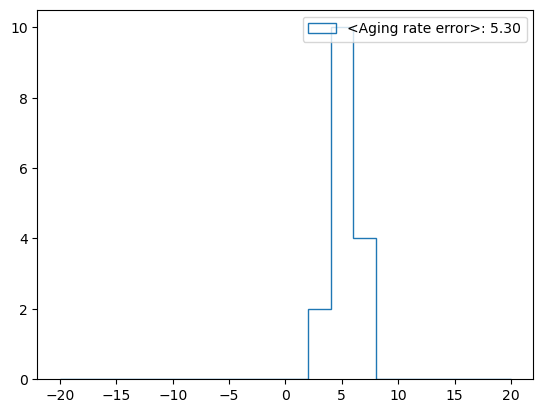

In [15]:
x=df_age.query('chan<8')['chi2_norm']
plt.hist(x, histtype='step', bins=20, range=(0,5), label="<Chi2>: %.2f"%x.mean());
plt.legend()

plt.figure()
x=df_age.query('feb==3 & chan<8')['age_rate']
plt.hist(x, histtype='step', bins=20, range=(-20, 20), label="<Aging rate (wrap)>: %.2f"%x.mean());
x=df_age.query('feb==7 & chan<8')['age_rate']
plt.hist(x, histtype='step', bins=20, range=(-20, 20), label="<Aging rate (tape)>: %.2f"%x.mean());
plt.legend()

plt.figure()
x=df_age.query('chan<8')['age_rate_std']
plt.hist(x, histtype='step', bins=20, range=(-20, 20), label="<Aging rate error>: %.2f"%x.mean());
plt.legend();

In [10]:
import datetime
current_time = datetime.datetime.now()
print(DATASET)
print("Current time:", current_time)

rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000-012.root
Current time: 2023-11-14 19:00:09.371491


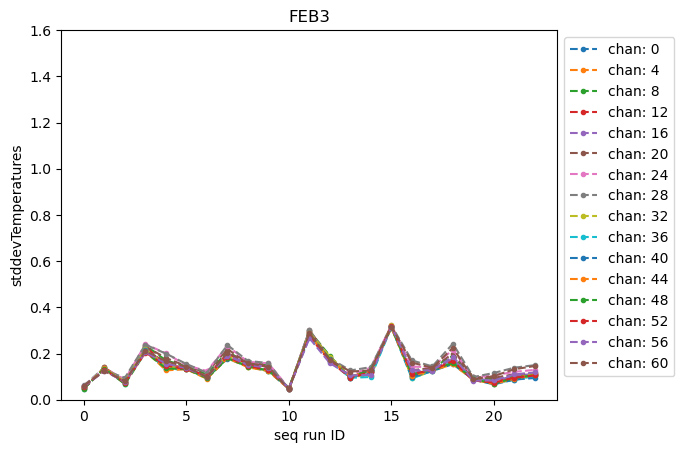

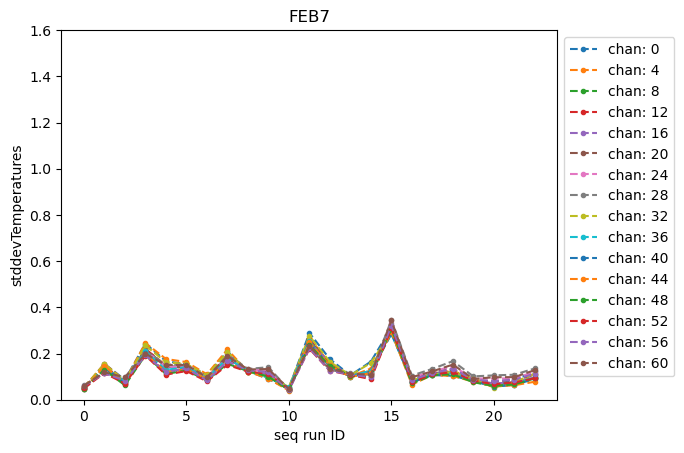

In [11]:
for feb, fid in enumerate([3,7]):
    plt.figure()
    for chan in range(0, 64, 4):
        plt.plot(ar['stddevTemperatures'][:,feb,chan], "--.", label="chan: %d"%chan);
    plt.ylabel('stddevTemperatures')
    plt.xlabel('seq run ID')
    plt.title('FEB%d'%fid)
    plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
    plt.ylim(0, 1.6)